# Table of contents

1. **Minimal approach:** how to run the code to read the DFT data, define the optimal model, and calculate the model coefficients.
2. **Plot results:** how to read the code results and plot the bands.
3. **Verify set alpha:** alternative code to verify if the selection is correct.
4. **Verify convergence:** check how the coefficients change with the number of remote bands.

# Minimal approach

In this first section we run the minimal code as shown in the paper.

**How to select set alpha?**

Here we avoid plotting figures to keep the code simple. So, to properly identify the set A (alpha), the user must plot the bands separatelly (via xmgrace, for instance) and identify the index of the relevant bands.

Alternativelly, the user can replace *step 3* with a more elaborated code shown in the section **Verify set alpha** below.

In [1]:
import numpy as np
import pydft2kp as dft2kp

In [2]:
%%capture
# avoid unecessary output from the irrep package

# step 1: read DFT data
kp = dft2kp.irrep(dftdir='HgI2_Monolayer',
                  outdir='outdir',
                  prefix='HgI2',
                  kpt=31,
                  kname='GM')

# step 2: read or calculate matrix elements of p
kp.get_p_matrices(qekp='kp.dat')

In [3]:
# step 3: define the set alpha
#         applies fold down via Löwdin
setA = np.arange(30, 36)
kp.define_set_A(setA)

Space group  115 : P-4m2
Group of the k-vector: <code not ready>
Verifying set A: [30 31 32 33 34 35]
Band indices: [30, 31] Irreps: (-GM6) Degeneracy: 2
Band indices: [32, 33] Irreps: (-GM7) Degeneracy: 2
Band indices: [34, 35] Irreps: (-GM7) Degeneracy: 2


In [4]:
# step 4: builds optimal model with qsymm
# s0, sx, sy, sz: Pauli matrices
from pydft2kp.constants import s0, sx, sy, sz
from scipy.linalg import expm

# Irreps E, A1 (from group D2d)
# D2d generator: S4 , (C2' or Sigma_d)

R2 = np.sqrt(2)/2

#=================================
# S4[0,0,1] ======================
#=================================
spin = np.array([[(1-1j)*R2, 0],
                 [0, (1+1j)*R2]])
#---------------------------------
orb = np.array([[+1,  0,  0],
                [ 0,  0, -1],
                [ 0,  1,  0]])
#---------------------------------
pR = np.array([[ 0,  1,  0],
               [-1,  0,  0],
               [ 0,  0, -1]])
#---------------------------------
pU = np.kron(spin, orb)           # wave-function basis
#---------------------------------
S4 = dft2kp.PointGroupElement(pR, False, False, pU)


#=================================
# C2[1,1,0] ======================
#=================================
spin = np.array([[0, (-1-1j)*R2],
                 [(1-1j)*R2, 0]])
#---------------------------------
orb = np.array([[+1,  0,  0],
                [ 0,  1, 0],
                [ 0,  0, -1]])
#---------------------------------
pR = np.array([[ 0,  1,  0],
               [ 1,  0,  0],
               [ 0,  0, -1]])
#---------------------------------
pU = np.kron(spin, orb)           # wave-function basis
#---------------------------------
C2 = dft2kp.PointGroupElement(pR, False, False, pU)


#---------------------------------
# TRS ----------------------------
#---------------------------------
orb = np.eye(3)
spin = 1j*sy
pU = np.kron(spin, orb)
TRS = dft2kp.time_reversal(3, U = pU)

symms = [S4, C2, TRS]
qs = dft2kp.qsymm(symms, dim=3, total_power=2, prettify=True, print_model=True, summed=True);

Matrix([
[                                                                                        c0 + c12*k_x**2 + c12*k_y**2 + c23*k_z**2,                                 -c18*k_x*k_z + c18*k_y*k_z + I*c20*k_x*k_z + I*c20*k_y*k_z - c4*k_x + c4*k_y + I*c8*k_x + I*c8*k_y,                                 -c18*k_x*k_z - c18*k_y*k_z - I*c20*k_x*k_z + I*c20*k_y*k_z + c4*k_x + c4*k_y + I*c8*k_x - I*c8*k_y,                                                                                                                 -I*c5*k_x + c5*k_y, c1*(1 + I) + c10*k_z*(1 + I) + I*c13*k_x**2 + c13*k_y**2 + c16*k_x**2 + I*c16*k_y**2 + c21*k_x*k_y*(1 + I) + c24*k_z**2*(1 + I), c1*(1 - I) + c10*k_z*(-1 + I) - I*c13*k_x**2 + c13*k_y**2 + c16*k_x**2 - I*c16*k_y**2 + c21*k_x*k_y*(-1 + I) + c24*k_z**2*(1 - I)],
[                               -c18*k_x*k_z + c18*k_y*k_z - I*c20*k_x*k_z - I*c20*k_y*k_z - c4*k_x + c4*k_y - I*c8*k_x - I*c8*k_y,                                                                  c11*k

In [5]:
# step 5: calculate the representation matrices for each symmetry operation
kp.get_symm_matrices()
# (optional): adds anti-unitary symmetry
kp.add_antiunitary_symm(TRS, np.array([0,0,0]))

# step 6: calculates and applies the transformation U
optimal = dft2kp.basis_transform(qs, kp, diagonal=False)

# step 7: print results
optimal.print_report(sigdigits=3)

cn      a.u. (Ry, a0)    with (eV, nm)  units    k powers
----  ---------------  ---------------  -------  ----------
c0             0.044          0.598     eV       0
c1            -0.0164        -0.223     eV       0
c2            -0.0628        -0.855     eV       0
c3             0.0159         0.216     eV       0
c4            -0.023         -0.0165    eV.nm    x,y
c5             0.119          0.0858    eV.nm    x,y
c6            -0.0509        -0.0367    eV.nm    x,y
c7             0.0896         0.0645    eV.nm    x,y
c8             0.23           0.165     eV.nm    x,y
c9             0.135          0.0971    eV.nm    x,y
c10           -0.111         -0.0803    eV.nm    z
c11           -0.0555        -0.04      eV.nm    z
c12            0.794          0.0303    eV.nm²   xx,yy
c13           -0.221         -0.00841   eV.nm²   xx,yy
c14           -0.34          -0.0129    eV.nm²   xx,yy
c15            0.422          0.0161    eV.nm²   xx,yy
c16           -0.386         -0.0147  

# Plot results

Once the model is complete, we can plot the bands.

Here the `qe_plotter(...)` is a helper to read the DFT bands in gnuplot format and organize the data to be plotted in python. It provides

- a helper routine `set_labels_and_limits(...)` to fix plot labels and k axis
- kdist: 1D array for the axis points properly spaced
- k3D: list of (kx,ky,kz) for each point in kdist

In [6]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 18})

# kpath as run in the bands calculation of QE
kpath = [[         30,     30,      1],
         [R'$X$', R'$\Gamma$', R'$M$']]

# init plotter
bands = dft2kp.qe_plotter(kp, 'bands.gnu', kpath)

In [7]:
# crude and optimal models as H(kx,ky,kz)

# build crude model with all bands
H_crude_full = kp.build_H_of_k(all_bands=True)
# build crude model folded into set A
H_crude_setA = kp.build_H_of_k(all_bands=False)

# the optimal model for set was already computed
# in step 6 above: optimal.Heff

# compute the eigenenergies as a function k for the path used in QE's data
Efull = np.array([np.linalg.eigvalsh(H_crude_full(*kvec)) for kvec in bands.k3D])
EsetA = np.array([np.linalg.eigvalsh(H_crude_setA(*kvec)) for kvec in bands.k3D])
Ek = np.array([np.linalg.eigvalsh(optimal.Heff(*kvec)) for kvec in bands.k3D])

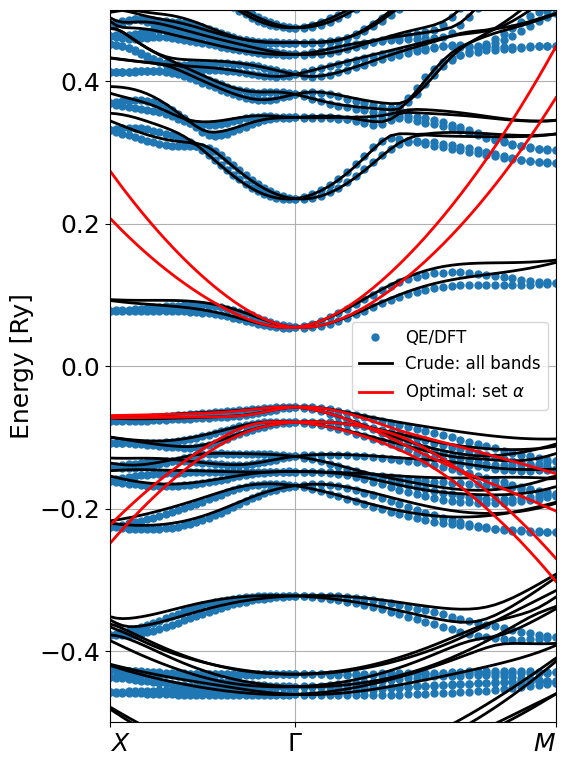

In [8]:
plt.figure(figsize=(6,8))
pdft   = plt.plot(bands.kdist, bands.bands, 'o', c='C0', ms=5)
pcrude = plt.plot(bands.kdist, Efull, c='black', lw=2)
poptim = plt.plot(bands.kdist, Ek, c='red', lw=2)
# set legends for single lines
pdft[0].set_label('QE/DFT')
pcrude[0].set_label('Crude: all bands')
poptim[0].set_label(r'Optimal: set $\alpha$')
plt.legend(fontsize=12)
bands.set_labels_and_limits(ax=plt.gca(), ymin=-0.5, ymax=0.5)
plt.grid()

plt.tight_layout()
basename = 'Figures/' + kp.dftdir.replace('/', '')
plt.savefig(basename + '.svg')
plt.savefig(basename + '.png')
plt.show()

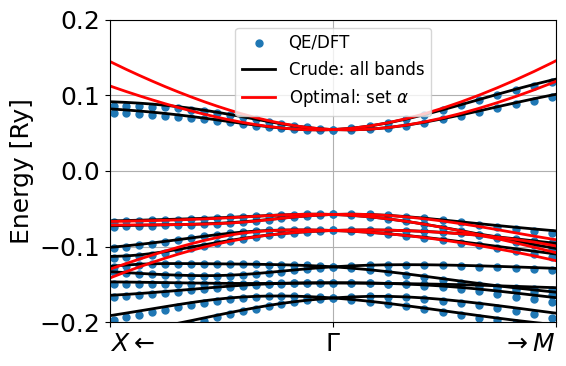

In [13]:
##############################################################
# ZOOM IN
##############################################################

plt.figure(figsize=(6,4))
pdft   = plt.plot(bands.kdist, bands.bands, 'o', c='C0', ms=5)
pcrude = plt.plot(bands.kdist, Efull, c='black', lw=2)
poptim = plt.plot(bands.kdist, Ek, c='red', lw=2)
# set legends for single lines
pdft[0].set_label('QE/DFT')
pcrude[0].set_label('Crude: all bands')
poptim[0].set_label(r'Optimal: set $\alpha$')
plt.legend(fontsize=12)
bands.set_labels_and_limits(ax=plt.gca(), ymin=-0.2, ymax=0.2, xmin=-4*dft2kp.a0, xmax=4*dft2kp.a0)
plt.grid()

plt.tight_layout()
basename = 'Figures/' + kp.dftdir.replace('/', '')
plt.savefig(basename + '-zoom.svg')
plt.savefig(basename + '-zoom.png')
plt.show()

# Verify set alpha

If the user wants to verify if set A (alpha) was chosen correctly, it is useful to plot the DFT bands emphasizing the set A.

In this case, add this steps to step 3 above:

1. Init matplotlib and plotter if necessary. See Plot results section above.
2. Plot the bands and set follwing this example:

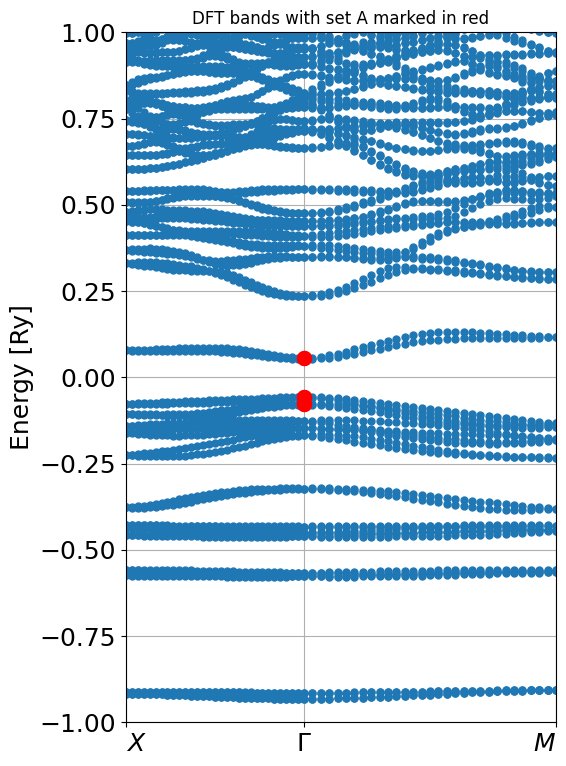

In [10]:
plt.figure(figsize=(6,8))
plt.title('DFT bands with set A marked in red', fontsize=12)
plt.plot(bands.kdist, bands.bands, 'o', ms=5, c='C0') # DFT
# ----------------------
# Emphasize set A in red
plt.scatter([0]*len(setA), bands.en_at_k[setA], c='red', s=100, zorder=10)
# ----------------------
bands.set_labels_and_limits(ax=plt.gca(), ymin=-1, ymax=1)
plt.grid()
plt.tight_layout()
plt.show()

# Verify convergence

To verify the convergence of the parameter as a function of the number of bands, one can redo the folding down with a reduced number of remote bands and plot how the coefficients change as a function of the number of remote bands.

In [11]:
nbands = len(kp.energies)
NBs = np.arange(0, nbands - setA[-1], 5)
cns = []
for NB in NBs:
    # redo fold down using only NB remote bands
    kp.fold_down_H(NB=NB)
    # identify and store list of coefficients
    cns += [list(optimal.getHeff(qs, kp)[0])]
cns = np.array(cns)

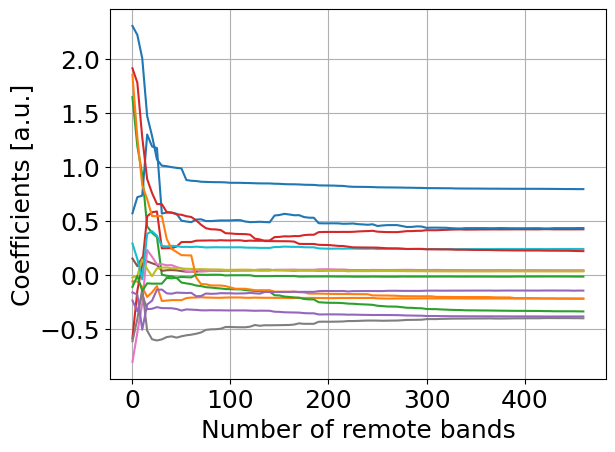

In [12]:
for n in range(cns.shape[1]):
    # only k² or larger powers depend on number of remote bands
    if set(optimal.keys[n]) & set([0, 'x','y','z']):
        continue
    plt.plot(NBs, cns[:,n], label=optimal.keys[n])
# plt.legend(fontsize=10)
plt.xlabel('Number of remote bands')
plt.ylabel(r'Coefficients [a.u.]')
plt.grid()
plt.show()